In [340]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

In [341]:
def f(x):
    y = 3*(x**2) - 4*x + 5
    return y

In [342]:
f(3.0)

20.0

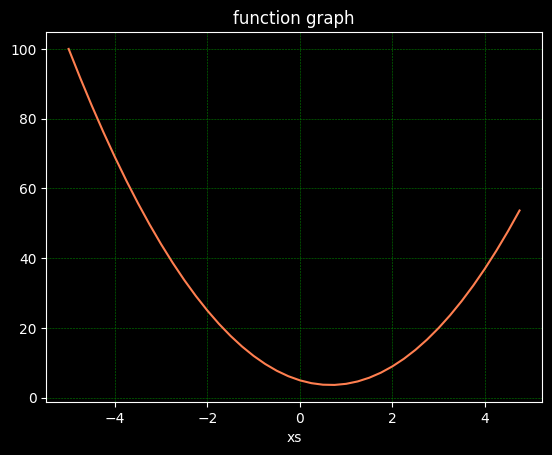

In [343]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys, c = 'coral')
plt.title("function graph")
plt.xlabel("xs")
plt.grid(color = 'green', linestyle = '--', linewidth = 0.4)

In [344]:
h = 0.0001
x = 3.0
(f(x + h) - f(x))/h

14.000300000063248

In [345]:
class Value:
  
  # note: consider the word "children" in the reverse graph sense.
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self._prev = set(_children)
    self._backward = lambda: None
    self.grad = 0.0
    self._op = _op
    self.label = label

  # repr for class pretty print
  def __repr__(self):
    return f"Value(label={self.label} data={self.data})"
  
  def __add__(self, other):
    # if other is a Value assign to itself, otherwise it must be a constant, so wrap it as a Value first.
    other = other if isinstance(other, Value) else Value(other)

    # do the addition operation.
    out = Value(self.data + other.data, (self, other), '+')

    def _local_derivative_of_each_child():
      # see Note 1 below, that with addition operation, the derivative for each child operand is
      # always 1.  Then due to the chain rule, we multiple by the derivative of the output.  
      # Note, we need += instead of equal because the chain rule is additive if the same node is 
      # differentiated multiple times.
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad

    # for the result of add operation, link to a lambda function that can compute the derivative 
    # for each of the two child operands.
    out._backward = _local_derivative_of_each_child

    return out

  # If someone tries to add a+2, that is covered above, where the 2 will be wrapped as a Value.
  # However, if someone tries, 2+a, then the 2 can;t be converted into a value, Python checks if __radd__
  # is defined, and self is from a, and other is 2, we can then call add.
  def __radd__(self, other): # other + self
    return self + other

  def __mul__(self, other):
    # if other is a Value assign to itself, otherwise it must be a constant, so wrap it as a Value first.
    other = other if isinstance(other, Value) else Value(other)

    # do the multiply operation.
    out = Value(self.data * other.data, (self, other), '*')

    def _local_derivative_of_each_child():
      # see Note 1 below, that with multiplication operation, the derivative for one child operand is
      # always value of other child operand in the multiply.  Then due to chain rule, we multiply with 
      # the derivative of the output.  Note, we need += instead of
      # equal because the chain rule is additive if the same node is differentiated multiple times.
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad

    # for the result of add operation, link to a lambda function that can compute the derivative 
    # for each of the two child operands.
    out._backward = _local_derivative_of_each_child

    return out

  # If someone tries to multiply a*2, that is covered above, where the 2 will be wrapped as a Value.
  # However if someone tries, 2*a, then the 2 can;t be converted into a value, Python checks if __rmul__
  # is defined, and self is from a, and other is 2, we can then call mult.
  def __rmul__(self, other):
    return self * other

  def exp(self):
    x = self.data

    # do the e**x operation.
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _local_derivative_of_each_child():
      self.grad += out.data * out.grad 
    out._backward = _local_derivative_of_each_child
    
    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _local_derivative_of_each_child():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _local_derivative_of_each_child

    return out

  def __truediv__(self, other): # self / other
    # do the division through multiply of reciprocal operation.
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def tanh(self):
    x = self.data

    # definition of tanh in terms of e**x,  See Note 3
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    # tanh has only one child.  Derivative is calculated symbolically with calculus. See Note 3.
    def _local_derivative_of_each_child():
      self.grad += (1 - t**2) * out.grad
    out._backward = _local_derivative_of_each_child
    
    return out
  # Call _backward() on each node in reverse topological order.  See Note #2 for detail.  
  def backward(self):

      # topological order all of the children in the graph
      topo = []
      visited = set()
      def build_topo(v):
          if v not in visited:
              visited.add(v)
              for child in v._prev:
                  build_topo(child)
              topo.append(v)
      build_topo(self)

      # go one variable at a time and apply the chain rule to get its gradient
      self.grad = 1
      for v in reversed(topo):
          v._backward()      

In [346]:
# Helper function
def get_list_of_Values_nice(x):
  nicelist = [p.data for p in x]
  return nicelist

In [347]:
# draw nodes in graph/tree visualization.
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [348]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')

# Here L is like our "loss" function.  The scalar values above are like our "weights".
L = d * f; L.label = 'L' # ((a*b)+c)*f
L
L._prev

{Value(label=d data=4.0), Value(label=f data=-2.0)}

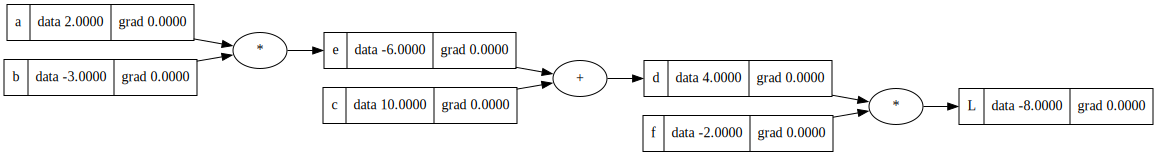

In [349]:
draw_dot(L)

In [350]:
# if L is like the loss function and the values are like the weights, we will want to do backpropagation to 
# figure out optimal weights that minimize the L, the loss function.  We start by computing the derivative 
# of each weight with respect to L

# We add a variable named "grad" to Value class to hold the derivative of that value with respect to L.  
# grad is initialized to 0 which means 0 slope, or that changes in this variable does not induce changes in L.

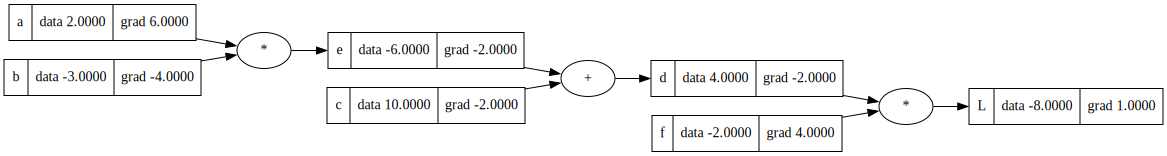

In [351]:
# Note 1

# dL/dL is always 1
#
# dL/dd is d(d*f)/dd since L=d*f.  By calculus, that is just f.  dL/dd = d(d*f)/dd = f.
# dL/df is d(d*f)/df since L=d*f.  By calculus, that is just d.  dL/df = d(d*f)/df = d.
# so with the multiplication operation, the derivative of L by one operand is the value of the other.
#
# We will compute dL/dc and DL/de by the chain rule.  dL/dc = dd/dc * DL/dd.
# dd/dc is d(e+c)/dc since d = e+c.  By calculus, that is just 1. dd/dc = 1.  
# thus DL/dc = 1 * DL/dd = 1 * f = f  
# so with the addition operations, the derivative of L by one operated is the derivative of the result of the addition.
# so then DL/de is also DL/de = 1 * DL/dd = 1 * f = f
# 
# We can keep going up the tree with * and +, using the chain rule to get gradients for all.
L.grad =  1  # this is dL/dL = 1 by definition.
f.grad =  4  # this is dL/df = d which is value  4. 
d.grad = -2  # this is dL/dd = f which is value -2. 
c.grad = -2  # this is dL/dc = 1*f which is value -2. 
e.grad =  -2 # this is dL/de = 1*f which is value -2. 
b.grad =  -4 #  2*(-2) this is dL/db which is the value of a * dL/de = 2*(-2) which is value of -4 
a.grad =   6 # -3*(-2) this is dL/da which is the value of b * dL/de = -3*(-2) which is value of 6 
draw_dot(L)

In [352]:
# now that we have the gradients, we do do a gradient decent.  For each leaf node (a, b, c, and f), we can move a tiny step in 
# the direction of the gradient.  Moving in the direction of the gradient should increase L.  Lets try.
step = 0.01
a.data += step*a.grad
b.data += step*b.grad
c.data += step*c.grad
f.data += step*f.grad

# recompute the forward pass
e = a * b
d = e + c
L = d * f
print(L.data) # it works, -7.286 is bigger than -8!!!

-7.286496


In [353]:
# so clearly, for each operation we have, we need to have the derivate computation as well.
# so to our value function, lets compute the derivative for each operation.



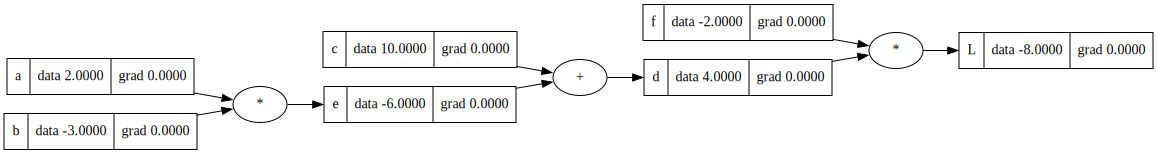

In [354]:
# Now that we have added the ability to compute derivative of each child operand from the output of each operation,
# lets do the backpropagation in a more automated way.

# start out by resetting the computational graph:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L' # ((a*b)+c)*f

draw_dot(L)

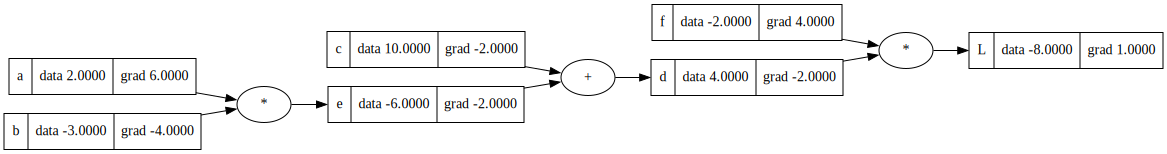

In [355]:
L.grad = 1.0  # start at one, dL/dL is always 1
L._backward() # from L, compute the gradients for the children operands (f and d)
d._backward() # from d, compute the gradients for the children operands (c and e)
e._backward() # from e, compute the gradients for the children operands (a and b)

draw_dot(L)

In [356]:
# To automatically traverse from L to d, to e, we need a topological sort.  Here is an example:
Image(url="topo.png", width=600)

In [357]:
# Here is the algorithm for topological order all of the children in a tree like ours
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(L)

In [358]:
# you can see we visit in the order of f, d, and e as desired.  We also have the leaf nodes c, a, b, and f in there
# but they don;t matter, because when we call _backward() on them, it is a Null function.
for node in reversed(topo): 
    print(node)

Value(label=L data=-8.0)
Value(label=f data=-2.0)
Value(label=d data=4.0)
Value(label=c data=10.0)
Value(label=e data=-6.0)
Value(label=b data=-3.0)
Value(label=a data=2.0)


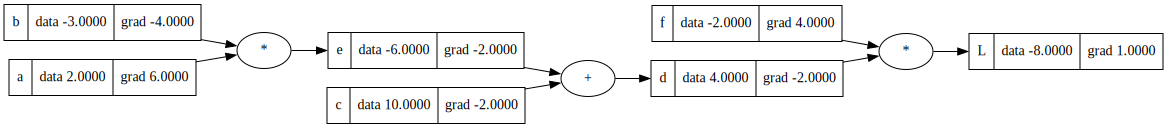

In [359]:
# Note 2

# So now we know how to automatically traverse in the right order, and call _backward, lets add a function
# in our Value class called backward() do to this all for us.

# start out by resetting the computational graph:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L' # ((a*b)+c)*f

# Now call our new function.
L.backward()

draw_dot(L) # viola!! we got all the gradients backpropagated correctly!!!

In [360]:
# Now lets build a simple 1 cell neuron.  We have 3 element input vector, X.  
# We have 3 corresponding weights.  We do the dot product.  Add a single bias value.  
# Then pass the result through an activation function that usually squashes the outputs in the extremes. 
Image(url="neuron_model.jpeg", width=400)

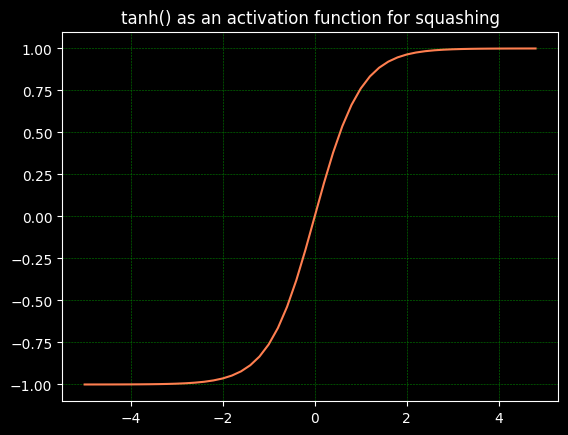

In [361]:
# One choice for activation function that usually squashes the outputs in the extremes is tanh. 
x = np.arange(-5,5,0.2)
plt.plot(x, np.tanh(x),c = 'coral')
plt.title("tanh() as an activation function for squashing")
plt.grid(color = 'green', linestyle = '--', linewidth = 0.4)


In [362]:
# Note 3

# tanh is defined mathematically as: tanh(x) = ((e**2x) - 1) / ((e**2x) + 1).  The derivative of tanh is also:
# d tanh(x) / dx = 1 - (tanh(x))**2

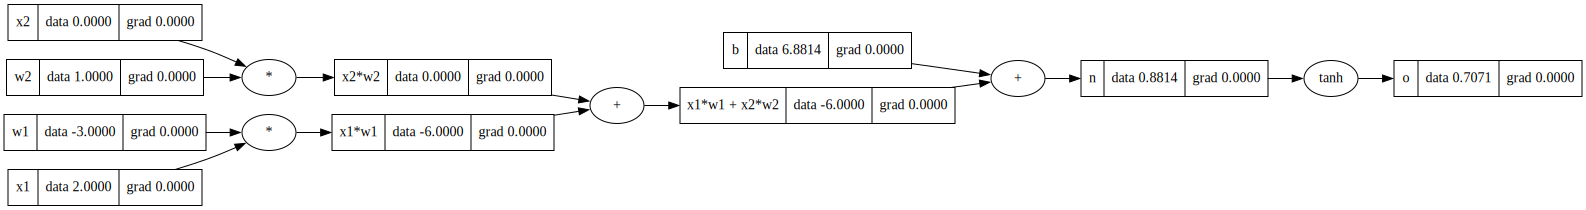

In [363]:
# Our neuron is thus:

# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b') # we set the bias this way to make the gradient numbers look good

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'

# x2*w2
x2w2 = x2*w2; x2w2.label = 'x2*w2'

# add both products together to get dot product x1w1x2w2 = x1w1 + x2*w2 = x1*w1 + x2*w2
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

# now add bias to the dot product (x1w1x2w2 + b) and name that n: 
n = x1w1x2w2 + b; n.label = 'n'

# finally apply the activation function, tanh, and name the result o:
o = n.tanh(); o.label = 'o'

draw_dot(o)

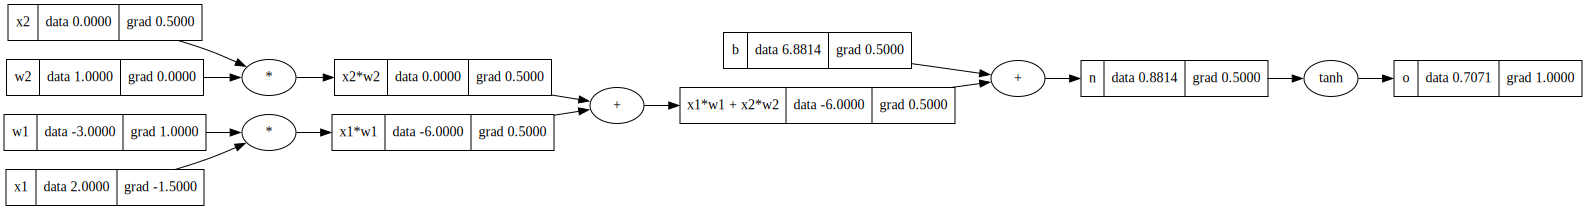

In [364]:
# now backpropagate
o.backward()

draw_dot(o)

In [365]:
# OK now, let's build out the the following Neural Network for real.  We will do it with similarity to pytorch API.
# A neural network is a connection of Neurons.  So lets define a generic neuron first.  Remember a Neuron looks like the 
# below.
Image(url="neuron_model.jpeg", width=400)

In [366]:
class Neuron:
  
  # Create a constructor for Neuron class.  Initialize the Neuron with number of inputs, nin.  For example, in the picture above, the neuron 
  # has 3 inputs.
  def __init__(self, nin):
    # Creating a list in python is easy.
    # a = [i for i in range(3)] would give a list of a=[0, 1, 2], or 
    # a = [3 for _ in range(3)] would give a list of a=[3, 3, 3] or
    # a = [Value(random.uniform(-1,1)) for _ in range(3)] would give a list of three Value objects, with each Value objects having a random value.
    # To create a list of nin weights, with w being a list of nin random values, we have
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]

    # Ceate a single bias, as a single Vaule with a random number.
    self.b = Value(random.uniform(-1,1))
  
  # Once an instance object of Neuron class is created, make the object itself callable 
  # with with x as an input.  x is a list of input values and return the forward pass of the neuron
  # which is the dot product of weights and input, the addition of the bias, and the application
  # of the activation function.
  def __call__(self, x):
    # w * x + b

    # So first we want the multiplication of all elements of X with all elements of W.
    # We want x0*w0, x1*w1, x2*w2 and so on.  the python operator takes 2 iterables and creates 
    # tuples with both.  Since both X and W are lists, then xi, xi in zip(w, x) would produce the following
    #
    # for example if 
    # a = [i for i in range(3)] then a = [0, 1, 2] and
    # b = [chr(ord('a')+i) for i in range(3)] then b = ['a', 'b', 'c']
    # so,
    # z = zip(a, b) then z is an iterable over tuples (ai, bi), the set constructor takes iterable as input, so
    # s = set(z) and
    # print(s) is: {(1, 'b'), (2, 'c'), (0, 'a')}
    # or create a list:
    # pz = [(ai,bi) for (ai, bi) in zip(a, b)] gives: [(0, 'a'), (1, 'b'), (2, 'c')]
    # or to create an iterable:
    # it = ((ai,bi) for (ai, bi) in zip(a, b))
    #
    # so create the wi*bi and sum them up, we;d do:
    # sum((wi*xi for (wi, xi) in zip(self.w, x))
    # then we can just add the b onto the end.
    # sum((wi*xi for (wi, xi) in zip(self.w, x)), self.b)
    act = sum((wi*xi for (wi, xi) in zip(self.w, x)), self.b)

    # use tanh as the activation function.
    out = act.tanh()

    # done with our Nueron.
    return out

  # return a list of all parameters in the neuron.  A list of all weights 
  # and the one bias 
  def parameters(self):
    # take the list of weits and append the bias as a list to make a new list that
    # combines them both.
    return self.w + [self.b]

In [367]:
# Now lets define a layer in a neural network.  
# A layer has a number of inputs,and outputs and is composed of Neurons.
# Since each individual Neuron has one output, the number of outputs of the layer is the 
# total number of Neurons in the layer.  The number of inputs to the layer is the same as 
# the number of inputs to each Neuron in the layer, since all inputs go to to each individual Neuron.
# The picture is as as follows:
Image(url="mlp.png", width=500)

# In the picture below a single layer is set of nodes (circles) grouped in a box filled with color.  
# See in the picture that the output of any node is sent as input to all nodes in the next layer.


In [368]:
# Define a layer
class Layer:
  
  # Constructor for class Layer.  A layer has a number of inputs and outputs and is composed of Neurons.
  def __init__(self, nin, nout):
    # Since each individual Neuron has one output, the number of outputs of the layer is the 
    # total number of Neurons in the layer.  So create a list called Neurons that that has 
    # nout Neuron objects in it.  Each Neuron object in the list has nin inputs, since The number of 
    # inputs to the layer is the same as  the number of inputs to each Neuron in the layer, since all 
    # inputs go to to each individual Nueron
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  # Once an instance object of Layer class is created, make the object itself callable 
  # with with x as an input.  x is a list of input values and return a list of the results for 
  # the forward pass of each output node.  If there is only one output node, return the result
  # of the forward pass directly instead of as a list of one.
  def __call__(self, x):

    # create a list of the results for the forward pass of each output node.  We pass the same input x, into 
    # each output node n (we will get different output results for each n since the weights and biases are different
    # for each node).
    outs = [n(x) for n in self.neurons]

    # If there is only one output node, return the result of the forward pass directly instead of as a list of one.
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    # in each layer we have a list of neurons that we need to iterate over, and then each neuron, we need to
    # iterate over each parameter, and thus create one linear list with all parameters.
    # Lets go over a simple example first.
    # 
    # I the b's are like neurons, and we have 3, each with 3 params, then we have: 
    # b1 = [1,2,3]
    # b2 = [4,5,6]
    # b3 = [7,8,9]
    #
    # And then a layer, a, would be a list of all the neurons, a list of the b's"
    # a = [b1,
    #      b2,
    #      b3]
    #
    # Just listing out the b's directly would give us all the parameters but still 3 lists:
    # list = [b for b in a]
    # print(list) will give [[1, 2, 3], [4, 5, 6], [7, 8, 9]]
    #
    # Taking the iteration over the b;s in a as "for b in a" and then adding an iteration over each
    # individual b, with iteration index p, "p for p in b" gives:
    # list = [p for b in a for p in b] 
    # print(list) will give: [1, 2, 3, 4, 5, 6, 7, 8, 9]
    return [p for neuron in self.neurons for p in neuron.parameters()]


In [369]:
# Now lets combine multiple layers together to form a full network called a MLP (Multi-Layer-Perceptrons) 
Image(url="mlp.png", width=500)

In [370]:
class MLP:
  
  def __init__(self, number_of_input_nodes_in_input_layer, list_of_sizes_of_each_layer_post_input_layer):
    # Create a single list of sizes of each layer starting with the number of nodes in the input layer followed
    # by the number of nodes in each hidden layer and ending with the number of nodes in the output layer.
    # To do this, just turn the first param,  number_of_input_nodes_in_input_layer into a list, and then just append
    # the second param, that is already a list, list_of_sizes_of_each_layer_post_input_layer.
    sz = [number_of_input_nodes_in_input_layer] + list_of_sizes_of_each_layer_post_input_layer

    # Now that we know the number of inputs and the number of nodes (synonymous with number of outputs) for each layer,
    # create a list with instance of each layer as a Layer object.  So if the network has 3 inputs, 2 hidden layers with 
    # the first hidden layer with 4 nodes, and the second hidden layer with 5 nodes, and then the output layer with 
    # 2 nodes, we'd have sz = [3, 4, 5, 2].  Note in this example we are just takeing the number of circles in the diagram above
    # ignoring the "..." part.  We don;t need to create a separate layer for the input layer, since no computation happens at the input layer.
    # We start at the second layer, (the first hidden layer) would have 3 inputs (coming from the input layer) and output to 4 nodes in 
    # the next layer, so that first layer would be created as Layer(3, 4).  The second layer (the second hidden layer), has 4 inputs and 
    # outputs to 5 nodes, so the second layer would be created as Layer(4, 5).  The third layer (the output layer) has 5 inputs and 
    # outputs to 2 nodes, so the last layer would be created as Layer(5, 2).  Note how we iterate with index i with Layer(sz[i], sz[i+1])
    # to get this overlapping affect.
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(list_of_sizes_of_each_layer_post_input_layer))]
  
  # Do the full forward computation of the network
  def __call__(self, x):
    # iterate across all the layers, starting with with the inputs, then apply the inputs to the first hidden layer,
    # take the outputs of the first hidden layer and make those inputs again for the next layer, and iterate till we get
    # to the end which is the output layer.
    for layer in self.layers:
      x = layer(x)
    return x
  
  # Collect all parameters in the whole network.  See comment in Layers class for more details.
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [371]:
# So lets implemet this specifc MLP:
Image(url="mlp1.jpeg", width=500)

Value(label= data=-0.9588480330865292)


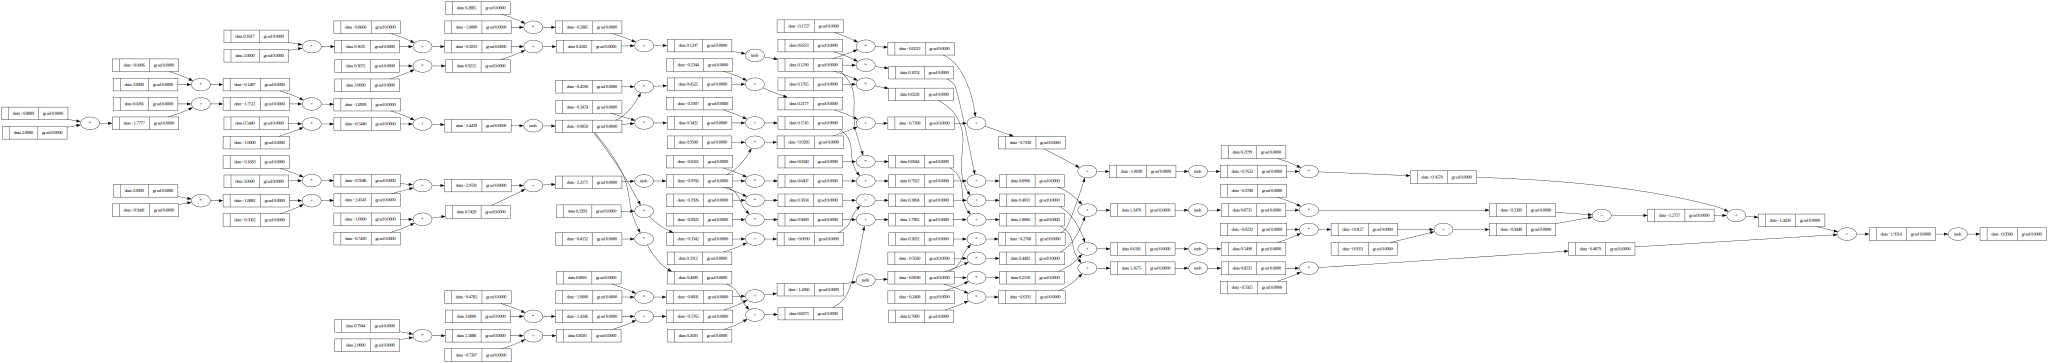

In [372]:
# choose input as  [2.0, 3.0, -1.0]
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
L = n(x)
print(L)
draw_dot(L)

In [373]:
# Now with multiple samples of X and desired (target) outputs:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [374]:
# to see what the current weights and biases do for these inputs:
ypred = [n(x) for x in xs]
yprednice = [y.data for y in ypred]

print(f"current outputs {get_list_of_Values_nice(ypred)}\nvs\ndesired outputs {ys}")

current outputs [-0.9588480330865292, -0.9168416275974574, -0.9395564525344429, -0.9331204121851441]
vs
desired outputs [1.0, -1.0, -1.0, 1.0]


In [375]:
# Lets use mean square error (MSE) as a loss function:
squared_errors = [(y_out-y_ground_truth)**2 for (y_ground_truth, y_out) in zip(ys, ypred)]
print(get_list_of_Values_nice(squared_errors))
loss = sum(squared_errors)

[3.8370856167269642, 0.006915314900639967, 0.0036534224302210584, 3.736954528006861]


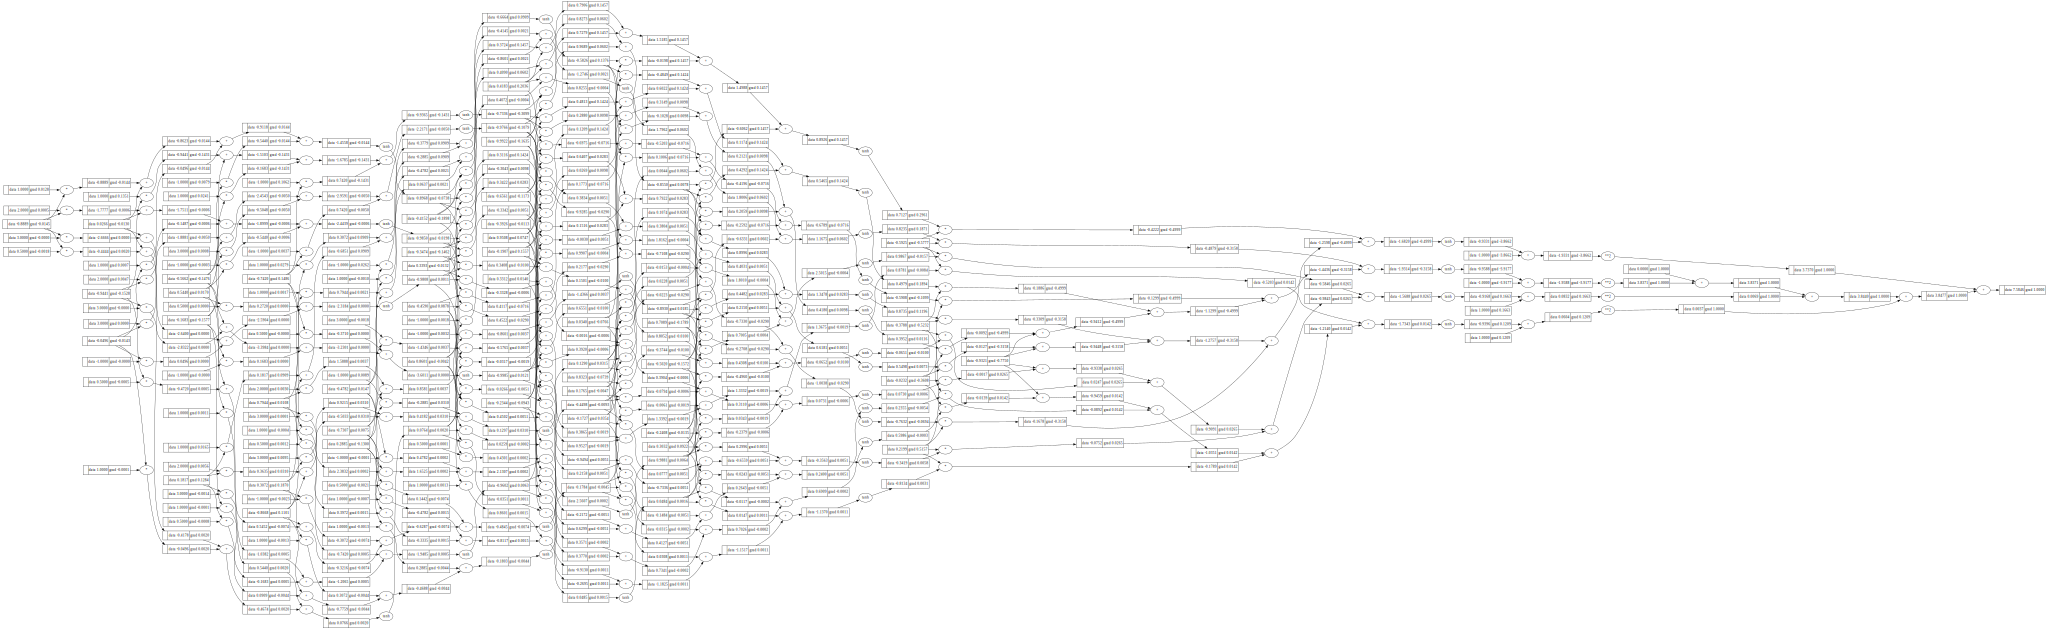

In [376]:
# So now we can do back prop:
loss.backward()
draw_dot(loss)

In [377]:
# Now lest adjust all weights and bias in small step away from each gradient, to make the loss smaller.
for p in n.parameters():
    p.data += -0.01 * p.grad

In [378]:
# Now lets do it in a loop over and over.  Full gradient decent.
for k in range(20):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  for p in n.parameters():
    p.grad = 0.0 # need to zero out the gradients after each step.
  loss.backward()
  
  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad
  
  print(k, loss.data)

0 7.563737830206441
1 7.285669341826059
2 6.604798895935126
3 4.867089580883418
4 3.218231979401121
5 1.8776949353174341
6 0.8896884396623705
7 0.43249528079168925
8 0.25470178613941025
9 0.18144963244483
10 0.13961019639540645
11 0.11263998383318
12 0.09393138063911123
13 0.08025600286373798
14 0.06985912153097631
15 0.06170942158104718
16 0.05516308691315758
17 0.04979845533879621
18 0.04532835781598189
19 0.041550770299926085
